#### Defect Equations for the Upper and Lower Points on the Defective Surfaces

The equations governing the defect locations are:


\begin{aligned}
    X_{ih} &= X_i + u_i - a_i \cdot \frac{h}{2}, & X_{ib} &= X_i + u_i + a_i \cdot \frac{h}{2}, \\ 
    Y_{ih} &= Y_i + v_i - b_i \cdot \frac{h}{2}, & Y_{ib} &= Y_i + v_i + b_i \cdot \frac{h}{2}.
\end{aligned}

### Figures Representing Dimensions and Parametrization

The figures below depict the dimensions of the problem and the parametrization. Each dimension has a tolerance of \(\pm 0.05\), resulting in a total tolerance interval of \(t = 0.1\).

<div style="display: flex; justify-content: space-around;">
    <figure>
        <img src="../Pictures/TCarres2DDims.png" width="300"/>
        <figcaption>Figure 1: Problem Dimensions</figcaption>
    </figure>
    <figure>
        <img src="../Pictures/TCarres2DGapPara.png" width="300"/>
        <figcaption>Figure 2: Gap Parametrization</figcaption>
    </figure>
    <figure>
        <img src="../Pictures/TCarres2DDimsDefPara.png" width="300"/>
        <figcaption>Figure 3: Defect Dimensions and Parametrization</figcaption>
    </figure>
</div>

#### Linear System Construction

Using the above equations, the following linear system is constructed:

$$
\mathbf{A} \cdot \mathbf{J} + \mathbf{b} = 0,
$$

where:

$$
\begin{array}{ccc}
\mathbf{A} =
\begin{bmatrix}
    -1 & 0  & 0 & -1 & 0 & 0 & 0 & 0 \\
    0  & 1  & 1 & 0  & 0 & 0 & 0 & 0 \\
    0  & 0  & 0 & 0  & -1 & 0 & 0 & -1 \\
    0  & 0  & 0 & 0  & 0 & 1 & 1 & 0 \\
    -1 & 0  & 0 & 0  & 1 & 0 & 0 & 0 \\
    -1 & -1 & 0 & 0  & 0 & 0 & 0 & 0 \\
    0  & 0  & 0 & 0  & -1 & -1 & 0 & 0
\end{bmatrix},
& \quad
\mathbf{J} =
\begin{bmatrix}
    J_{1b} \\
    J_{2b} \\
    J_{3b} \\
    J_{4b} \\
    J_{1h} \\
    J_{2h} \\
    J_{3h} \\
    J_{4h}
\end{bmatrix},
& \quad
\mathbf{b} =
\begin{bmatrix}
    Y_{1b} - X_{1b} + X_{4b} - Y_{4b} \\
    Y_{2b} - X_{2b} + X_{3b} - Y_{3b} \\
    Y_{1h} - X_{1h} + X_{4h} - Y_{4h} \\
    Y_{2h} - X_{2h} + X_{3h} - Y_{3h} \\
    Y_{1b} - X_{1b} + X_{1h} - Y_{1h} \\
    Y_{1b} - X_{1b} + X_{2b} - Y_{2b} \\
    Y_{1h} - X_{1h} + X_{2h} - Y_{2h}
\end{bmatrix}.
\end{array}
$$

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optimization and modeling
import openturns as ot
from scipy.optimize import milp, Bounds, LinearConstraint # linprog is depreceated and supperseded by milp

# Utilities
from joblib import Parallel, delayed
from functools import partial
import itertools
from tqdm import trange, tqdm

##### Model Data

In [2]:
# Geometric data
data = {
    "X1": 24.9, "X2": 35.1, "X3": 94.9, "X4": 105.1,
    "Y1": 25,   "Y2": 35,   "Y3": 95,   "Y4": 105,
}
X1, X2, X3, X4 = data["X1"], data["X2"], data["X3"], data["X4"]
Y1, Y2, Y3, Y4 = data["Y1"], data["Y2"], data["Y3"], data["Y4"]

# Model parameters
h = 10    # Feature height
t = 0.1   # Tolerance interval
Cm = 0.3  # Process capability index

# Linear optimization bounds
borne_inf_jeu = 0
borne_sup_jeu = 20 * t
bounds = [(borne_inf_jeu, borne_sup_jeu)] * 8

# Standard deviations for errors
sigma_e_pos = t / (6 * Cm)            # Positional error
theta_max = t / h                     # Maximum orientation error
sigma_e_theta = (2 * theta_max) / (6 * Cm)  # Orientation standard deviation


##### Linear System Construction

In [3]:
# Equality matrix for linear constraints
A_eq = np.array([
    [-1,  0,  0, -1,  0,  0,  0,  0],
    [ 0,  1,  1,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0, -1,  0,  0, -1],
    [ 0,  0,  0,  0,  0,  1,  1,  0],
    [-1,  0,  0,  0,  1,  0,  0,  0],
    [-1, -1,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0, -1, -1,  0,  0], 
])

##### Functions

In [4]:
def compute_positions(H_i, u_i, a_i, inv=False):
    """
    Compute new positions for a given dimension.

    Parameters:
    -----------
    H_i : float
        Original position of the feature.
    u_i : float
        Translational error.
    a_i : float
        Orientation error.
    inv : bool, optional
        Inversion flag (default: False).

    Returns:
    --------
    tuple[float, float]
        New upper (H_ih) and lower (H_ib) positions.
    """
    if inv:
        H_ih = H_i - u_i - (a_i * h / 2)
        H_ib = H_i - u_i + (a_i * h / 2)
    else:
        H_ih = H_i + u_i - (a_i * h / 2)
        H_ib = H_i + u_i + (a_i * h / 2)
    return H_ih, H_ib


def get_b_eq_from_errs(u1, a1, u2, a2, u3, a3, u4, a4, v1, b1, v2, b2, v3, b3, v4, b4):
    """
    Generate the equality constraint vector for linear optimization.

    Parameters:
    -----------
    u1, a1, ..., u4, a4 : float
        Translational and rotational errors for X-coordinates.
    v1, b1, ..., v4, b4 : float
        Translational and rotational errors for Y-coordinates.

    Returns:
    --------
    np.ndarray
        Vector of equality constraints (B_eq).
    """
    X1h, X1b = compute_positions(X1, u1, a1)
    X2h, X2b = compute_positions(X2, u2, a2, inv=True)
    X3h, X3b = compute_positions(X3, u3, a3)
    X4h, X4b = compute_positions(X4, u4, a4, inv=True)

    Y1h, Y1b = compute_positions(Y1, v1, b1, inv=True)
    Y2h, Y2b = compute_positions(Y2, v2, b2)
    Y3h, Y3b = compute_positions(Y3, v3, b3, inv=True)
    Y4h, Y4b = compute_positions(Y4, v4, b4)

    return np.array([
        Y1b - X1b + X4b - Y4b,
        Y2b - X2b + X3b - Y3b,
        Y1h - X1h + X4h - Y4h,
        Y2h - X2h + X3h - Y3h,
        Y1b - X1b + X1h - Y1h,
        Y1b - X1b + X2b - Y2b,
        Y1h - X1h + X2h - Y2h,
    ])


##### Optimization Configuration

In [5]:
# Method for linear optimization
method = "highs-ds"

##### Functions for Probability Distribution and Linear System

In [7]:
def get_composed_distribution_from_lambda(
    lambda_X_1, lambda_X_2, lambda_X_3, lambda_X_4,
    lambda_Y_1, lambda_Y_2, lambda_Y_3, lambda_Y_4
):
    """
    Creates a composed distribution for positional and angular defects.

    Parameters:
    -----------
    lambda_X_i, lambda_Y_i : float
        Weighting parameters for positional and orientation errors (0 <= lambda <= 1).

    Returns:
    --------
    openturns.ComposedDistribution
        A vector of positional and angular defect distributions.
    """    
    # Define positional and orientation distributions for each feature
    e_pos_X_1 = lambda_X_1 * ot.Normal(0, sigma_e_pos)
    e_ori_X_1 = (1 - lambda_X_1) * ot.Normal(0, sigma_e_theta)
    e_pos_X_2 = lambda_X_2 * ot.Normal(0, sigma_e_pos)
    e_ori_X_2 = (1 - lambda_X_2) * ot.Normal(0, sigma_e_theta)
    e_pos_X_3 = lambda_X_3 * ot.Normal(0, sigma_e_pos)
    e_ori_X_3 = (1 - lambda_X_3) * ot.Normal(0, sigma_e_theta)
    e_pos_X_4 = lambda_X_4 * ot.Normal(0, sigma_e_pos)
    e_ori_X_4 = (1 - lambda_X_4) * ot.Normal(0, sigma_e_theta)

    e_pos_Y_1 = lambda_Y_1 * ot.Normal(0, sigma_e_pos)
    e_ori_Y_1 = (1 - lambda_Y_1) * ot.Normal(0, sigma_e_theta)
    e_pos_Y_2 = lambda_Y_2 * ot.Normal(0, sigma_e_pos)
    e_ori_Y_2 = (1 - lambda_Y_2) * ot.Normal(0, sigma_e_theta)
    e_pos_Y_3 = lambda_Y_3 * ot.Normal(0, sigma_e_pos)
    e_ori_Y_3 = (1 - lambda_Y_3) * ot.Normal(0, sigma_e_theta)
    e_pos_Y_4 = lambda_Y_4 * ot.Normal(0, sigma_e_pos)
    e_ori_Y_4 = (1 - lambda_Y_4) * ot.Normal(0, sigma_e_theta)

    # Combine all distributions
    defect_distributions = ot.ComposedDistribution([
        e_pos_X_1, e_ori_X_1,
        e_pos_X_2, e_ori_X_2,
        e_pos_X_3, e_ori_X_3,
        e_pos_X_4, e_ori_X_4,
        e_pos_Y_1, e_ori_Y_1,
        e_pos_Y_2, e_ori_Y_2,
        e_pos_Y_3, e_ori_Y_3,
        e_pos_Y_4, e_ori_Y_4,
    ])

    # Set descriptive labels for distributions
    defect_distributions.setDescription([
        "e_pos_X_1", "e_ori_X_1",
        "e_pos_X_2", "e_ori_X_2",
        "e_pos_X_3", "e_ori_X_3",
        "e_pos_X_4", "e_ori_X_4",
        "e_pos_Y_1", "e_ori_Y_1",
        "e_pos_Y_2", "e_ori_Y_2",
        "e_pos_Y_3", "e_ori_Y_3",
        "e_pos_Y_4", "e_ori_Y_4",])
    return defect_distributions


class SolveLinearSystem(ot.OpenTURNSPythonFunction):
    """
    Solves a linear optimization system for defect evaluation using MILP.

    Inputs:
    -------
    16 positional and angular defects (e_pos_X, e_ori_X, e_pos_Y, e_ori_Y).

    Outputs:
    --------
    SUCCESS : int
        Indicates whether the optimization succeeded (1) or failed (0).
    """
    def __init__(self):
        super(SolveLinearSystem, self).__init__(16, 1)
        self.setInputDescription(
            [
                "e_pos_X_1", "e_ori_X_1", "e_pos_X_2", "e_ori_X_2",
                "e_pos_X_3", "e_ori_X_3", "e_pos_X_4", "e_ori_X_4",
                "e_pos_Y_1", "e_ori_Y_1", "e_pos_Y_2", "e_ori_Y_2",
                "e_pos_Y_3", "e_ori_Y_3", "e_pos_Y_4", "e_ori_Y_4",
            ]
        )
        self.setOutputDescription(["SUCCESS"])
        self.result = None

    def _exec(self, X):
        # Unpack input variables
        u1, a1, u2, a2, u3, a3, u4, a4, v1, b1, v2, b2, v3, b3, v4, b4 = X
        
        # Calculate the equality constraints
        b_eq = get_b_eq_from_errs(u1, a1, u2, a2, u3, a3, u4, a4, v1, b1, v2, b2, v3, b3, v4, b4)

        # Define cost function
        c = np.array([-1, 0, 0, 0, 0, 0, 0, 0])  # Minimize first gap

        # Define bounds for MILP
        bounds = Bounds(
            lb=np.full(8, borne_inf_jeu),  # Lower bounds
            ub=np.full(8, borne_sup_jeu),  # Upper bounds
            keep_feasible=False)

        # Define equality constraints
        eq_constraints = LinearConstraint(A_eq, -1*b_eq, -1*b_eq)

        RES = milp(c=c, bounds=bounds, constraints=[eq_constraints], options={"disp": False})
        success = int(RES.success)

        self.result = RES
        return [success]


def get_failure_prob_MC(lambdas, defect_sample=None, sizeMC=1e4, seedMC=9999):
    """
    Computes the failure probability using Monte Carlo simulation.

    Parameters:
    -----------
    lambdas : list[float]
        Weights for positional and angular defects.
    sizeMC : int, optional
        Number of Monte Carlo samples (default: 10,000).
    seedMC : int, optional
        Random seed for reproducibility (default: 9999).

    Returns:
    --------
    float
        Failure probability.
    """
    if not defect_sample :
        ot.RandomGenerator.SetSeed(seedMC)
        defect_distributions = get_composed_distribution_from_lambda(*lambdas)
        sampleMC = defect_distributions.getSample(int(sizeMC))
    ot_model = SolveLinearSystem()
    results = [ot_model(point)[0] for point in sampleMC]
    return 1 - sum(results) / len(results)


def get_imprecise_failure_probs(lambdaDOE, defect_sample=None, parallel=True):
    """
    Computes failure probabilities for a design of experiments over the imprecise space.

    Parameters:
    -----------
    lambdaDOE : array-like
        Design of experiments in the lambda parameter space.
    parallel : bool, optional
        Enable parallel computation (default: True).

    Returns:
    --------
    list[float]
        Failure probabilities for each configuration in the design of experiments.
    """
    if parallel:
        return Parallel(n_jobs=-3, verbose=3)(
            delayed(get_failure_prob_MC)(lambdas, defect_sample) for lambdas in lambdaDOE
        )
    return [get_failure_prob_MC(lambdas, defect_sample) for lambdas in tqdm(lambdaDOE)]

##### Lambda Sampling with LHS

In [8]:
# Define a uniform distribution for each lambda
lambda_dist_elementary = ot.Uniform(0, 1)
lambdas_dist = ot.ComposedDistribution([lambda_dist_elementary] * 8)

# Generate a Latin Hypercube Sample (LHS) of size N
N = 200
lhs = ot.LHSExperiment(lambdas_dist, N)
lhs.setAlwaysShuffle(True)  # Randomized sampling
design = lhs.generate()

##### Monte Carlo Simulation for Failure Probabilities

In [9]:
# Calculate failure probabilities for the design of experiments
failure_probs_MC = get_imprecise_failure_probs(design, parallel=True)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=-3)]: Done  92 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-3)]: Done 200 out of 200 | elapsed:  1.1min finished


##### Results Display

In [10]:
# Display the bounds on the failure probabilities
print("Lower probability of failure:", round(min(failure_probs_MC) * 100, 4), "%")
print("Upper probability of failure:", round(max(failure_probs_MC) * 100, 4), "%")

Lower probability of failure: 7.79 %
Upper probability of failure: 21.87 %


##### Visualization

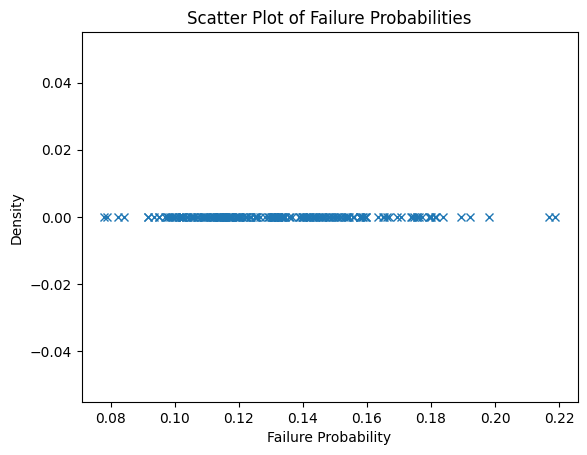

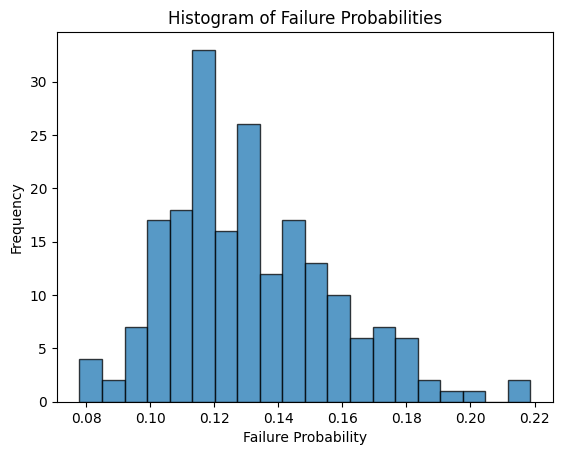

In [11]:
# Scatter plot of failure probabilities
plt.plot(failure_probs_MC, np.zeros_like(failure_probs_MC), "x")
plt.xlabel("Failure Probability")
plt.ylabel("Density")
plt.title("Scatter Plot of Failure Probabilities")
plt.show()

# Histogram of failure probabilities
plt.hist(failure_probs_MC, bins=20, alpha=0.75, edgecolor="black")
plt.xlabel("Failure Probability")
plt.ylabel("Frequency")
plt.title("Histogram of Failure Probabilities")
plt.show()